# Exercise 1

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics as me
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [2]:
# Load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
X_train, X_test = X_train / 255.0, X_test / 255.0

# Convert class vectors to binary class matrices (for use in categorical_crossentropy)
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [3]:
# Define the checkpoint directory and file
checkpoint_filepath = '/tmp/checkpoint'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

## Sequential strategy using the functional API

In [4]:
# Input shape is the shape of CIFAR-10 images
input_shape = (32, 32, 3)

# Define the input tensor
inputs = Input(shape=input_shape)

# Define the layers
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(300, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(10, activation='softmax')(x)

# Create the model
model1 = Model(inputs=inputs, outputs=outputs)

# Model summary
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                             

In [5]:
model1.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
log_model1 = model1.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=64, callbacks=[checkpoint_callback])

Epoch 1/10
625/625 [==============================] - ETA: 0s - loss: 1.6383 - accuracy: 0.3900
Epoch 1: val_accuracy improved from -inf to 0.53460, saving model to /tmp/checkpoint
625/625 [==============================] - 13s 12ms/step - loss: 1.6383 - accuracy: 0.3900 - val_loss: 1.2801 - val_accuracy: 0.5346
Epoch 2/10
622/625 [============================>.] - ETA: 0s - loss: 1.1769 - accuracy: 0.5791
Epoch 2: val_accuracy improved from 0.53460 to 0.62420, saving model to /tmp/checkpoint
625/625 [==============================] - 7s 11ms/step - loss: 1.1761 - accuracy: 0.5793 - val_loss: 1.0727 - val_accuracy: 0.6242
Epoch 3/10
621/625 [============================>.] - ETA: 0s - loss: 0.9620 - accuracy: 0.6625
Epoch 3: val_accuracy improved from 0.62420 to 0.68230, saving model to /tmp/checkpoint
625/625 [==============================] - 6s 10ms/step - loss: 0.9612 - accuracy: 0.6629 - val_loss: 0.8915 - val_accuracy: 0.6823
Epoch 4/10
621/625 [============================>.] - 

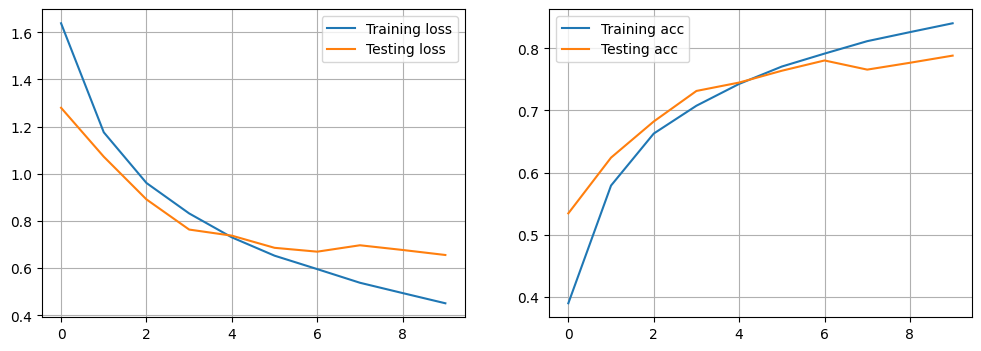

In [6]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log_model1.history['loss'], label='Training loss')
ax1.plot(log_model1.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log_model1.history['accuracy'], label='Training acc')
ax2.plot(log_model1.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

In [7]:
loss_test, metric_test = model1.evaluate(X_test, y_test, verbose=0)
print('model test loss:', loss_test)
print('model test accuracy:', metric_test)

model test loss: 0.6863976716995239
model test accuracy: 0.7795000076293945


## Multiple paths strategy

In [8]:
# Input layer
inputs = Input(shape=(32, 32, 3))

# Path 1: Larger filters
path1 = Conv2D(32, (5, 5), activation='relu', padding='same')(inputs)
path1 = MaxPooling2D((2, 2))(path1)
path1 = Conv2D(64, (3, 3), activation='relu', padding='same')(path1)
path1 = MaxPooling2D((2, 2))(path1)

# Path 2: Smaller filters
path2 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
path2 = Conv2D(32, (3, 3), activation='relu', padding='same')(path2)
path2 = MaxPooling2D((2, 2))(path2)
path2 = Conv2D(64, (3, 3), activation='relu', padding='same')(path2)
path2 = Conv2D(64, (3, 3), activation='relu', padding='same')(path2)
path2 = MaxPooling2D((2, 2))(path2)

# Concatenate both paths
combined = concatenate([path1, path2])

# Follow-up layers
x = Flatten()(combined)
x = Dropout(0.3)(x)
x = Dense(300, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(10, activation='softmax')(x)

# Create the model
model2 = Model(inputs=inputs, outputs=outputs)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 32, 32, 32)           896       ['input_2[0][0]']             
                                                                                                  
 conv2d_9 (Conv2D)           (None, 32, 32, 32)           9248      ['conv2d_8[0][0]']            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 32, 32, 32)           2432      ['input_2[0][0]']             
                                                                                            

In [9]:
log_model2 = model2.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=64, callbacks=[checkpoint_callback])

Epoch 1/10
625/625 [==============================] - ETA: 0s - loss: 1.4745 - accuracy: 0.4656
Epoch 1: val_accuracy did not improve from 0.78820
625/625 [==============================] - 10s 11ms/step - loss: 1.4745 - accuracy: 0.4656 - val_loss: 1.1500 - val_accuracy: 0.5803
Epoch 2/10
622/625 [============================>.] - ETA: 0s - loss: 1.0734 - accuracy: 0.6228
Epoch 2: val_accuracy did not improve from 0.78820
625/625 [==============================] - 5s 9ms/step - loss: 1.0728 - accuracy: 0.6229 - val_loss: 0.9149 - val_accuracy: 0.6846
Epoch 3/10
622/625 [============================>.] - ETA: 0s - loss: 0.9042 - accuracy: 0.6836
Epoch 3: val_accuracy did not improve from 0.78820
625/625 [==============================] - 6s 9ms/step - loss: 0.9034 - accuracy: 0.6838 - val_loss: 0.7993 - val_accuracy: 0.7251
Epoch 4/10
623/625 [============================>.] - ETA: 0s - loss: 0.7754 - accuracy: 0.7263
Epoch 4: val_accuracy did not improve from 0.78820
625/625 [========

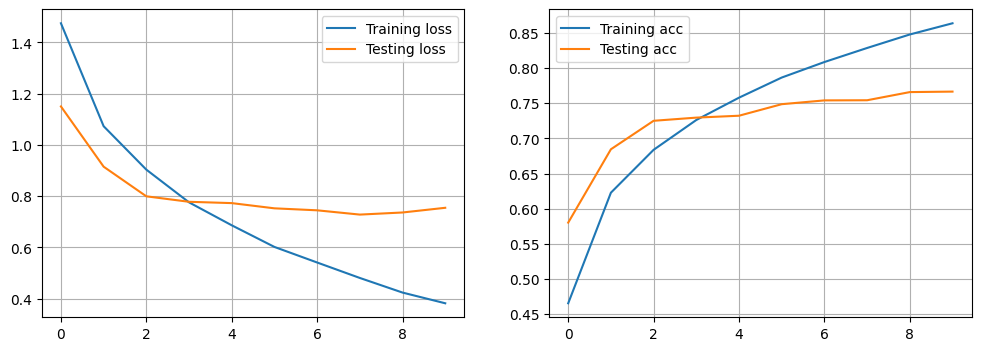

In [10]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log_model2.history['loss'], label='Training loss')
ax1.plot(log_model2.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log_model2.history['accuracy'], label='Training acc')
ax2.plot(log_model2.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

In [11]:
test_loss, test_acc = model2.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

313/313 [==============================] - 1s 4ms/step - loss: 0.7801 - accuracy: 0.7501
Test accuracy: 0.7501000165939331, Test loss: 0.7801382541656494


## Multiple features strategy

In [12]:
# Input layer
visible = Input(shape=(32, 32, 3))

# First feature extractor
conv1 = Conv2D(32, kernel_size=3, activation='relu')(visible)
drop1 = Dropout(0.2)(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(drop1)
flat1 = Flatten()(pool1)

# Second feature extractor
conv2 = Conv2D(32, kernel_size=3, activation='relu')(pool1)
drop2 = Dropout(0.2)(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(drop2)
flat2 = Flatten()(pool2)

# Third feature extractor
conv3 = Conv2D(32, kernel_size=3, activation='relu')(pool2)
drop3 = Dropout(0.2)(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)
flat3 = Flatten()(pool3)

# Merge feature extractors
merge = concatenate([flat1, flat2, flat3])

# Interpretation layer
hidden1 = Dense(100, activation='relu')(merge)

# Prediction output
output = Dense(10, activation='softmax')(hidden1)

# Create the model
model3 = Model(inputs=visible, outputs=output)

# Compile the model
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summarize layers
print(model3.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_12 (Conv2D)          (None, 30, 30, 32)           896       ['input_3[0][0]']             
                                                                                                  
 dropout_4 (Dropout)         (None, 30, 30, 32)           0         ['conv2d_12[0][0]']           
                                                                                                  
 max_pooling2d_7 (MaxPoolin  (None, 15, 15, 32)           0         ['dropout_4[0][0]']           
 g2D)                                                                                       

In [13]:
log_model3 = model3.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=64, callbacks=[checkpoint_callback])

Epoch 1/10
619/625 [============================>.] - ETA: 0s - loss: 1.4714 - accuracy: 0.4754
Epoch 1: val_accuracy did not improve from 0.78820
625/625 [==============================] - 7s 7ms/step - loss: 1.4697 - accuracy: 0.4760 - val_loss: 1.2645 - val_accuracy: 0.5622
Epoch 2/10
618/625 [============================>.] - ETA: 0s - loss: 1.1117 - accuracy: 0.6086
Epoch 2: val_accuracy did not improve from 0.78820
625/625 [==============================] - 4s 6ms/step - loss: 1.1102 - accuracy: 0.6093 - val_loss: 1.0921 - val_accuracy: 0.6363
Epoch 3/10
623/625 [============================>.] - ETA: 0s - loss: 0.9600 - accuracy: 0.6628
Epoch 3: val_accuracy did not improve from 0.78820
625/625 [==============================] - 4s 6ms/step - loss: 0.9599 - accuracy: 0.6630 - val_loss: 1.0176 - val_accuracy: 0.6513
Epoch 4/10
614/625 [============================>.] - ETA: 0s - loss: 0.8596 - accuracy: 0.6985
Epoch 4: val_accuracy did not improve from 0.78820
625/625 [==========

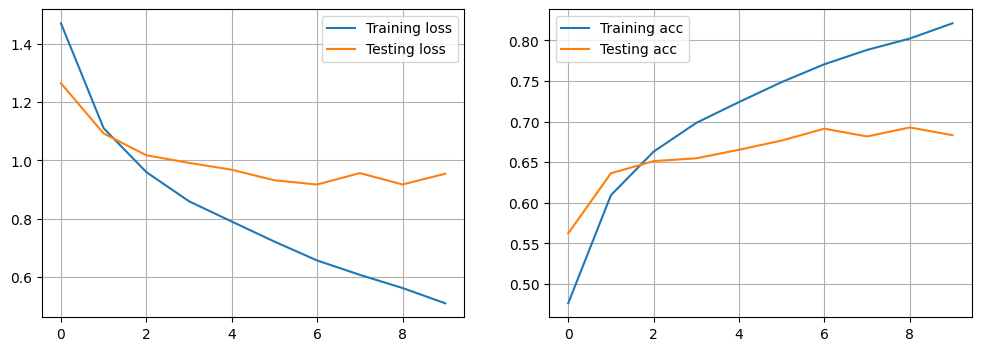

In [14]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log_model3.history['loss'], label='Training loss')
ax1.plot(log_model3.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log_model3.history['accuracy'], label='Training acc')
ax2.plot(log_model3.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

In [15]:
test_loss, test_acc = model3.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

313/313 [==============================] - 1s 3ms/step - loss: 0.9738 - accuracy: 0.6717
Test accuracy: 0.6717000007629395, Test loss: 0.9737797975540161
